In [1]:
import pandas as pd
import os

In [2]:
topic = 'feminism'
scheme = 'NNPred'

path = os.getcwd()
clean_path = f'{path}/clean/multiclass'
NN_path = f'{path}/NN/multiclass/{topic}/{scheme}'

train_file = f'{path}/train/labeled_{topic}_NNtrain.csv'
test_file = f'{path}/test/labeled_{topic}_test.csv'

os.makedirs(NN_path, exist_ok=True)
os.makedirs(f'{clean_path}/train', exist_ok=True)
os.makedirs(f'{clean_path}/test', exist_ok=True)

NN_path

'/media/rinnely/Archer1/ENES/Stance/Clasificador/NN/multiclass/feminism/NNPred'

In [ ]:
train = pd.read_csv(train_file)
train.head()

In [ ]:
train['NNPred'] = train[['NNFavor','NNAgainst']].apply(lambda x : 1 if x[0] >= 0.7 else( -1 if x[1] >= 0.70 else 0 ),axis=1)

In [ ]:
train = train[[f'{scheme}', 'Tweet']]
train.columns = ['Label', 'Tweet']
train.head()

In [ ]:
train.Label.unique()

In [ ]:
train.groupby('Label').count()

In [ ]:
test = pd.read_csv(test_file)
test.head()

In [ ]:
test = test[['Stance', 'Tweet']]
test.Stance.unique()

In [ ]:
test['Stance']= test.Stance.replace({'FAVOR':1, 'AGAINST':-1, 'NONE':0})
#test = test.query('Stance != 0')
test.Stance.unique()

In [ ]:
test.columns = ['Label', 'Tweet']
test.groupby('Label').count()

In [ ]:
train.shape, test.shape

# clean data

In [ ]:
import sys
sys.path.insert(0, '/media/rinnely/Archer1/ENES/Stance')
import cleandata as cd

In [ ]:
train = cd.cleanData(train.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')
test = cd.cleanData(test.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')

In [ ]:
train = train.dropna(axis=0)

# token

In [ ]:
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords 

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
tokenized_train = train['Tweet'].apply(lambda x: x.split())
tokenized_test = test['Tweet'].apply(lambda x: x.split())

In [ ]:
tokenized_test

In [ ]:
tokenized_train = tokenized_train.apply(lambda x:[item for item in x if 
                                    item not in stop_words]) 
tokenized_test = tokenized_test.apply(lambda x:[item for item in x if 
                                    item not in stop_words]) 

In [ ]:
tokenized_test

In [ ]:
train['detokens'] = tokenized_train.apply(lambda x: ' '.join(x))
test['detokens'] = tokenized_test.apply(lambda x: ' '.join(x))

In [ ]:
train

# save data

In [ ]:
train.to_csv(f'{clean_path}/train/clean_{topic}_{scheme}_train.csv', index=False)
test.to_csv(f'{clean_path}/test/clean_{topic}_{scheme}_test.csv', index=False)

# read data

In [3]:
train = pd.read_csv(f'{clean_path}/train/clean_{topic}_{scheme}_train.csv')
test = pd.read_csv(f'{clean_path}/test/clean_{topic}_{scheme}_test.csv')

In [ ]:
train['Label'].value_counts().plot.pie(legend=True)

In [ ]:
test['Label'].value_counts().plot.pie(legend=True)

In [ ]:
train['Label'].value_counts().plot.bar(legend=True)

In [ ]:
test['Label'].value_counts().plot.bar(legend=True)

In [ ]:
train

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
train = train.dropna(axis=0)

In [ ]:
train.info()

# Training

In [4]:
from fastai.text import *

In [5]:
data_lm = (TextList.from_df(train, NN_path, cols='Tweet')
          .split_by_rand_pct(0.1)
          .label_for_lm() # this does the tokenization and numericalization
          .databunch())
data_clas = TextClasDataBunch.from_df(NN_path, train_df=train, 
                                      valid_df=test, 
                                      vocab=data_lm.vocab, 
                                      text_cols = 'Tweet', 
                                      label_cols = 'Label',
                                      bs=16)

/home/rinnely/anaconda3/lib/python3.8/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [6]:
data_lm.save(f'data_lm_{topic}_{scheme}')
data_clas.save(f'data_clas_{topic}_{scheme}')

In [ ]:
data_lm.train_ds.vocab.itos[:10], len(data_lm.train_ds.vocab.itos)

In [7]:
#learn = ftxt.language_model_learner(data_lm, arch=ftxt.AWD_LSTM, drop_mult=.2)
learn_lm = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=1.)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 5.25E-02


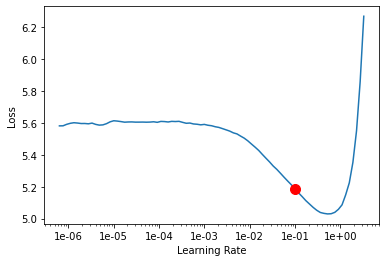

In [8]:
learn_lm.lr_find(); learn_lm.recorder.plot(suggestion=True)

In [9]:
learn_lm.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.248697,4.171646,0.241964,00:06
1,4.625713,3.643578,0.303497,00:06
2,4.247355,3.546738,0.313765,00:06
3,4.010253,3.527728,0.313914,00:06
4,3.870436,3.520849,0.317113,00:06


In [ ]:
learn_lm.unfreeze()
learn_lm.lr_find(); learn_lm.recorder.plot(suggestion=True)

In [ ]:
learn_lm.fit_one_cycle(3)

In [10]:
learn_lm.save_encoder(f'{topic}_ml_encoder_v1')
learn_lm.save(f'{topic}_model_v1')

In [ ]:
learn_lm.load_encoder(f'{topic}_ml_encoder_v1');
learn_lm.load(f'{topic}_model_v1');

In [11]:
from sklearn.metrics import f1_score

@np_func #converts torch tesnsor as numpy array
def f1_macro(inp, targ): 
    return f1_score(targ, np.argmax(inp, axis=1), labels=[0, 2], pos_label=None, average='macro')

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=1.)
learn.load_encoder(f'{topic}_ml_encoder_v1')
learn.metrics=[f1_macro]
learn.freeze()

In [12]:
learn.save('learner-1stage')

In [ ]:
learn.load('learner-1stage');

In [ ]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
learn.fit_one_cycle(3,3e-3,moms=(0.8, 0.7))

In [ ]:
learn.save('learner-2stage')

In [ ]:
learn.load('learner-2stage');

In [ ]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(3, slice(6e-3/3,6e-3),moms=(0.8, 0.7))

In [ ]:
learn.save('learner-3stage')

In [ ]:
learn.load('learner-3stage');

In [ ]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, moms=(0.8, 0.7))

In [ ]:
learn.freeze_to(-2)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(3,2e-6,moms=(0.8, 0.7));

In [ ]:
learn.save('learner-stage-freeze-2')

In [ ]:
learn.save('learner-stage-freeze-2')

In [ ]:
learn.freeze_to(-3)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(3, moms=(0.8, 0.7))

In [ ]:
learn.save('learner-stage-freeze-3')

In [ ]:
learn.load('learner-stage-freeze-3');

In [ ]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, moms=(0.8, 0.7))

In [ ]:
learn.save('learner-stage-unfreeze-68')

learn.load('learner-stage-unfreeze-68');

In [ ]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = TextClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [ ]:
interp.top_losses(10)

In [ ]:
interp.show_top_losses(10)

In [ ]:
learn.save('learner-final')